In [41]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import optimize, linalg
from math import erf, erfc
from scipy.optimize import *
from agent import Agent


def overlap(a1,a2):
    return np.exp(-0.5*abs(a1-a2)**2)

def rho0(B, pr_at0=0.5):
    return pr_at0*np.outer(*[B[:,0]]*2) + (1-pr_at0)*np.outer(*[B[:,1]]*2)
def rho1(B, pr_at0=0.5):
    return pr_at0*np.outer(*[B[:,2]]*2) + (1-pr_at0)*np.outer(*[B[:,3]]*2)

def helstrom_success_fun(amplitude, epsilon1=1e-2, epsilon2=1.):
    at1 = np.sqrt(epsilon1)
    at2 = np.sqrt(epsilon2)
    a1=amplitude
    a2=-amplitude
    gram = np.zeros((4,4))
    for indi, i in enumerate([at1*a1, at2*a1, at1*a2, at2*a2]):
        for indj, j in enumerate([at1*a1, at2*a1, at1*a2, at2*a2]):
            gram[indi,indj] = overlap(i,j)
    B = linalg.sqrtm(gram)
    q0 = 0.5
    q1 = 1-q0
    rho = q0*rho0(B) - q1*rho1(B)
    trace_norm = np.sum(np.abs(np.linalg.eigvals(rho)))
    helstrom_success = (1+trace_norm)/2
    return helstrom_success

def homodyne_success(a):
    return (1+ erf(np.sqrt(2)*a))/2

def fading_homodyne_success(a, epsilon1=1e-2,epsilon2=1. ,pat0=0.5):
    return pat0*homodyne_success(np.sqrt(epsilon1)*a) + (1-pat0)*homodyne_success(np.sqrt(epsilon2)*a)



def Pr(alpha, beta, bs_at, outcome, channel_params=None):
    if channel_params is None:
        p= np.exp(-abs(alpha + beta)**2)
    else:
        pis, ats = channel_params #### [[pi, 1-pi], [epsilon, 1]]
        p=0
        for pfading, at in zip(pis,ats):
           p+= pfading*np.exp(-abs(np.sqrt(at)*alpha*bs_at + beta)**2)
    if outcome==0.:
        return p
    else:
        return 1-p
    
def Ptotoutcome(prior_plus,alpha,beta, bs_at, outcome, channel_params=None):
    return prior_plus*Pr(alpha,beta, bs_at, outcome,channel_params) + (1-prior_plus)*Pr(-alpha,beta, bs_at, outcome, channel_params)

def error_probability_1L(betas, amplitude, channel):
    b0= betas[0]
    p=0
    for n1 in [0.,1.]:
        ph = [-1,1][np.argmax([Pr(ph*amplitude, b0 ,1, n1, channel) for ph in [-1,1]])]
        p+=Pr(ph*amplitude, b0 ,1, n1, channel)/2
    return 1-p


def error_probability_2L(betas, amplitude, channel):
    b0, b1 ,b2 = betas
    p=0
    for n1,n2 in zip([0,0,1,1],[0,1,0,1]):
        bp = []
        for ph in [-1,1]:
            f=0
            for patt,att in zip(channel[0], channel[1]):
                f+=patt*agent.P(np.sqrt(att)*ph*amplitude, b0 ,1/np.sqrt(2), n1)*agent.P(np.sqrt(att)*ph*amplitude, [b1,b2][n1] ,1/np.sqrt(2), n2)/2
            bp.append(f)
        p+=np.max(bp)
    return 1-p

channels = {}
channels[0] = [[.5,.5],[1,1]]
channels[1] = [[.5,.5],[.01,1]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
caseid=1
agent = Agent()
amps=np.linspace(1,2,100)

attenuations = channels[caseid][1]
fading_channel = channels[caseid]
betas = np.linspace(-max(amps)*2,2*max(amps),1000)
s1,fun1 = np.zeros((2,len(amps)))
s2 = np.zeros((len(amps)))
fun2 = np.zeros((len(amps),3))

for inda,a in tqdm(enumerate(amps)):

    seed = betas[np.argmin([error_probability_1L([b], a, fading_channel) for b in betas])]
    ff = minimize(error_probability_1L,x0=seed, method="BFGS", args=(a,fading_channel),bounds=[tuple([None, None])])
    s1[inda]= 1-ff.fun
    fun1[inda]= ff.x


for inda,a in tqdm(enumerate(amps)):


    f=dual_annealing(error_probability_2L,([(-max(2*a,1),max(2*a,1))])*3, args=[a, fading_channel], maxiter=5000,no_local_search=True)
    s2[inda] = 1-f.fun
    fun2[inda] = f.x


homodynes_values = np.array([fading_homodyne_success(a, epsilon1=attenuations[0], epsilon2=attenuations[1]) for a in amps])
helstroms_values = np.array([helstrom_success_fun(a,epsilon1=attenuations[0], epsilon2=attenuations[1]) for a in amps])

os.makedirs("datos_id/{}".format(caseid),exist_ok=True)
np.save("datos_id/{}/ar_2L_s".format(caseid),s2)
np.save("datos_id/{}/ar_2L_betas".format(caseid),fun2)
np.save("datos_id/{}/ar_1L_s".format(caseid),s1)
np.save("datos_id/{}/ar_1L_betas".format(caseid),fun1)
np.save("datos_id/{}/homodynes".format(caseid),homodynes_values)
np.save("datos_id/{}/helstroms".format(caseid),helstroms_values)


100it [00:10,  9.64it/s]
100it [19:39, 11.80s/it]


In [19]:
ammps = np.linspace(0,3,100)
sss2 = np.load("data_cases/1/ar_2L_s.npy")
hells = np.load("data_cases/1/helstroms.npy")

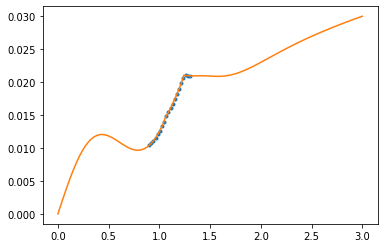

In [32]:
plt.plot(amps,helstroms_values-s2,'.')
plt.plot(ammps, (hells-sss2))

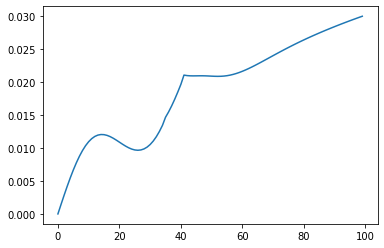

In [25]:
plt.plot(hells-sss2)

In [34]:
import numpy as np

from bokeh.models import Label
from bokeh.plotting import figure, show
from bokeh.util.compiler import TypeScript

TS_CODE = """
import * as p from "core/properties"
import {Label, LabelView} from "models/annotations/label"
declare const katex: any

export class LatexLabelView extends LabelView {
  model: LatexLabel

  render(): void {
    //--- Start of copied section from ``Label.render`` implementation

    // Here because AngleSpec does units tranform and label doesn't support specs
    let angle: number
    switch (this.model.angle_units) {
      case "rad": {
        angle = -this.model.angle
        break
      }
      case "deg": {
        angle = (-this.model.angle * Math.PI) / 180.0
        break
      }
      default:
        throw new Error("unreachable code")
    }

    const panel = this.panel != null ? this.panel : this.plot_view.frame

    const xscale = this.plot_view.frame.xscales[this.model.x_range_name]
    const yscale = this.plot_view.frame.yscales[this.model.y_range_name]

    let sx = this.model.x_units == "data" ? xscale.compute(this.model.x) : panel.xview.compute(this.model.x)
    let sy = this.model.y_units == "data" ? yscale.compute(this.model.y) : panel.yview.compute(this.model.y)

    sx += this.model.x_offset
    sy -= this.model.y_offset

    //--- End of copied section from ``Label.render`` implementation
    // Must render as superpositioned div (not on canvas) so that KaTex
    // css can properly style the text
    this._css_text(this.plot_view.canvas_view.ctx, "", sx, sy, angle)

    // ``katex`` is loaded into the global window at runtime
    // katex.renderToString returns a html ``span`` element
    katex.render(this.model.text, this.el, {displayMode: true})
  }
}

export namespace LatexLabel {
  export type Attrs = p.AttrsOf<Props>

  export type Props = Label.Props
}

export interface LatexLabel extends LatexLabel.Attrs {}

export class LatexLabel extends Label {
  properties: LatexLabel.Props

  constructor(attrs?: Partial<LatexLabel.Attrs>) {
    super(attrs)
  }

  static initClass() {
    this.prototype.default_view = LatexLabelView
  }
}
LatexLabel.initClass()
"""


class LatexLabel(Label):
    """A subclass of the Bokeh built-in `Label` that supports rendering
    LaTex using the KaTex typesetting library.

    Only the render method of LabelView is overloaded to perform the
    text -> latex (via katex) conversion. Note: ``render_mode="canvas``
    isn't supported and certain DOM manipulation happens in the Label
    superclass implementation that requires explicitly setting
    `render_mode='css'`).
    """
    __javascript__ = ["https://cdnjs.cloudflare.com/ajax/libs/KaTeX/0.6.0/katex.min.js"]
    __css__ = ["https://cdnjs.cloudflare.com/ajax/libs/KaTeX/0.6.0/katex.min.css"]
    __implementation__ = TypeScript(TS_CODE)


x = np.arange(0.0, 1.0 + 0.01, 0.01)
y = np.cos(2 * 2 * np.pi * x) + 2

p = figure(title="LaTex Demonstration", plot_width=500, plot_height=500)
p.line(x, y)

# Note: must set ``render_mode="css"``
latex = LatexLabel(text="f = \sum_{n=1}^\infty\\frac{-e^{i\pi}}{2^n}!",
                   x=40, y=420, x_units='screen', y_units='screen',
                   render_mode='css', text_font_size='16pt',
                   background_fill_alpha=0)

p.add_layout(latex)

show(p)

RuntimeError: node.js v14.0.0 or higher is needed to allow compilation of custom models ("conda install nodejs" or follow https://nodejs.org/en/download/)

## Generate plots